# Stock Prices Prediction Using AI and Machine Learning

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models
from keras.src.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Creating a dataframe of the stock data

In [ ]:
stock_df = pd.read_csv('NVDA.csv', index_col='Date', parse_dates=["Date"])
print(f"Dataset Shape: {stock_df.shape}")
stock_df.head(5)

Dataset Shape: (1259, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-11,36.597500,37.145000,36.125000,36.612499,36.328110,49518000
2019-02-12,37.000000,37.950001,36.855000,37.792500,37.498962,59106000
2019-02-13,38.090000,38.957500,37.952499,38.220001,37.923134,60537200
2019-02-14,38.209999,38.917500,37.775002,38.632500,38.332417,82726400
2019-02-15,40.737499,40.967499,39.105000,39.334999,39.029465,151674800


## Data Preprocessing

In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-02-11 to 2024-02-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [6]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,189.512762,193.001130,185.993276,189.726307,189.507869,4.566096e+07
std,137.234296,139.429077,134.982183,137.484063,137.540024,1.874352e+07
min,33.977501,34.367500,33.150002,33.445000,33.257332,9.788400e+06
25%,78.305000,80.572502,76.736252,78.400002,78.118095,3.238370e+07
50%,151.960007,154.729996,149.500000,152.652496,152.361816,4.277960e+07
75%,242.184998,248.584999,237.310005,242.930000,242.595398,5.517475e+07
max,705.330017,721.849976,702.119995,721.330017,721.330017,1.543911e+08


In [7]:
stock_df.nunique()

Open         1236
High         1242
Low          1244
Close        1246
Adj Close    1251
Volume       1258
dtype: int64

### Checking for duplicates

In [8]:
if stock_df.duplicated(keep=False).any():
    print(stock_df.loc[stock_df.duplicated(keep=False), :])
else:
    print("No duplicates found")

No duplicates found


### Checking for Null values

In [9]:
null_vals = stock_df.isnull().sum()
if null_vals.sum() > 0:
    print(null_vals)
else:
    print("No null values found")

No null values found


## Stock Visualization

Splitting the stock data for Training (80%) and Test (20%) data

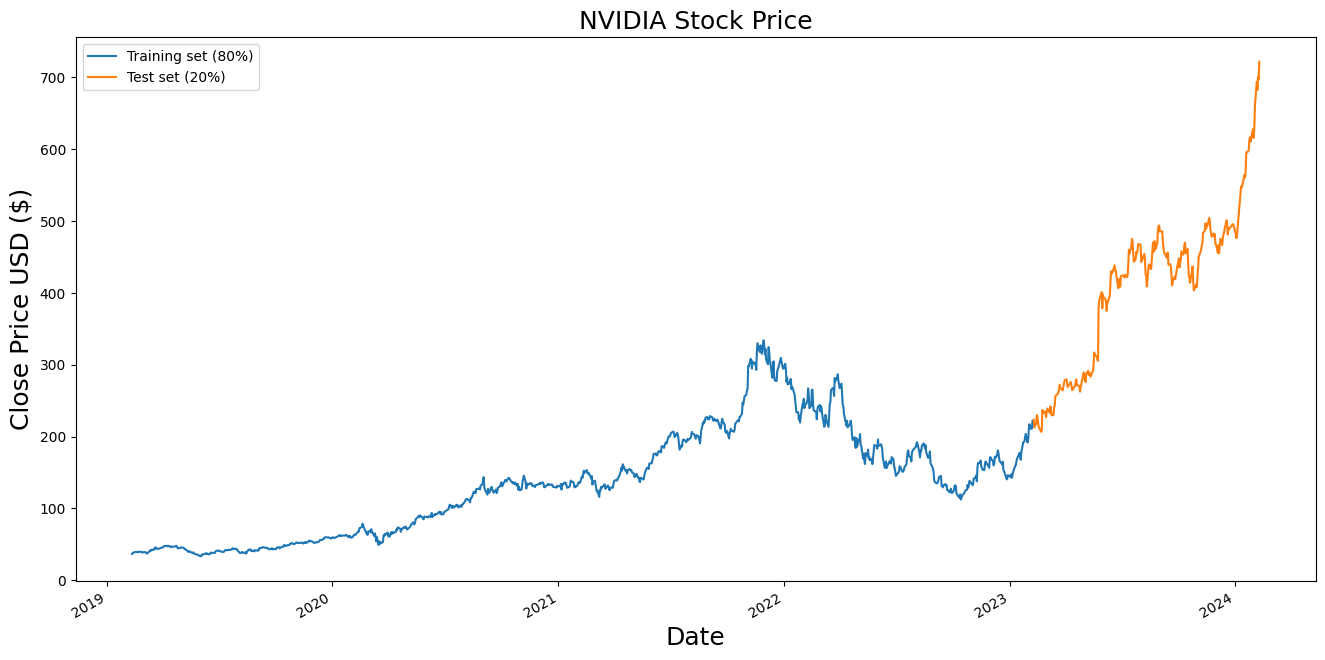

In [10]:
plt.figure(figsize=(10, 6))
train_data = stock_df["Close"][:int(len(stock_df)*0.8)]
test_data = stock_df["Close"][int(len(stock_df)*0.8):]
train_data.plot(figsize=(16, 8), legend=True)
test_data.plot(figsize=(16, 8), legend=True)
plt.legend(['Training set (80%)', 'Test set (20%)'])
plt.title('NVIDIA Stock Price', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## Data Processing

In [11]:
data = stock_df.filter(['Close'])
dataset = data.values
training_data_len = int(len(data) * 0.8)
print(f"Training Data length: {training_data_len}")

Training Data length: 1007


### Scaling/Normalizing the dataset

In [12]:
mmsc = MinMaxScaler(feature_range=(0,1))
scaled_data = mmsc.fit_transform(dataset)
scaled_data

array([[0.00460469],
       [0.0063201 ],
       [0.00694157],
       ...,
       [0.97043107],
       [0.96377295],
       [1.        ]])

### Creating sequential training data for LSTM

In [13]:
train_data = scaled_data[0:int(training_data_len), :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (947, 60, 1)
y_train shape: (947,)


### Correlation Matrix with Heatmap

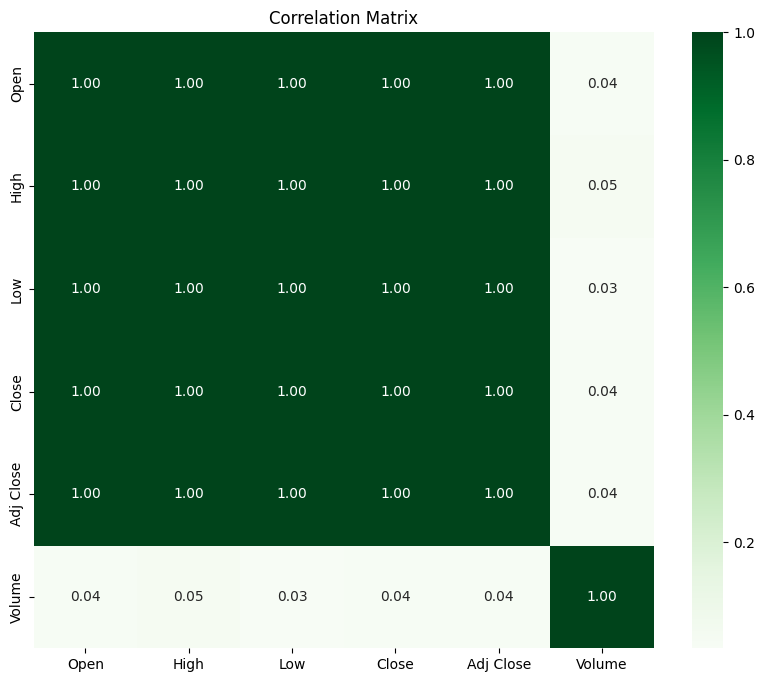

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(stock_df.corr(), annot=True, cmap=plt.cm.Greens, fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

## Model Training

- **Long Short-Term Memory (LSTM)** network is a Recurrent Neural Network (RNN), aimed to deal with the vanishing gradient problem present in traditional RNNs.
- It expects the input in the form of a sequence of features.
- It is useful for data such as time series or string of text.

### Creating LSTM

In [29]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compiling and training LSTM

In [30]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100
30/30 [==============================] - 4s 10ms/step - loss: 0.0042
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 4.5993e-04
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 3.1499e-04
Epoch 4/100
30/30 [==============================] - 0s 8ms/step - loss: 3.1551e-04
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 2.8058e-04
Epoch 6/100
30/30 [==============================] - 0s 9ms/step - loss: 2.5682e-04
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 2.3936e-04
Epoch 8/100
30/30 [==============================] - 0s 11ms/step - loss: 2.5031e-04
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 2.1054e-04
Epoch 10/100
30/30 [==============================] - 0s 11ms/step - loss: 1.9008e-04
Epoch 11/100
30/30 [==============================] - 0s 10ms/step - loss: 1.8799e-04
Epoch 12/100
30/30 [==============================] - 0s 11ms/step - los

### Creating sequential testing dataset and calculating RMSE

In [31]:
test_data = scaled_data[training_data_len - 60: , :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

predictions = model.predict(X_test)
predictions = mmsc.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"\nRoot Mean Square Error: {rmse}")

8/8 [==============================] - 1s 6ms/step

Root Mean Square Error: 11.533315835258325


### Evaluation and Results

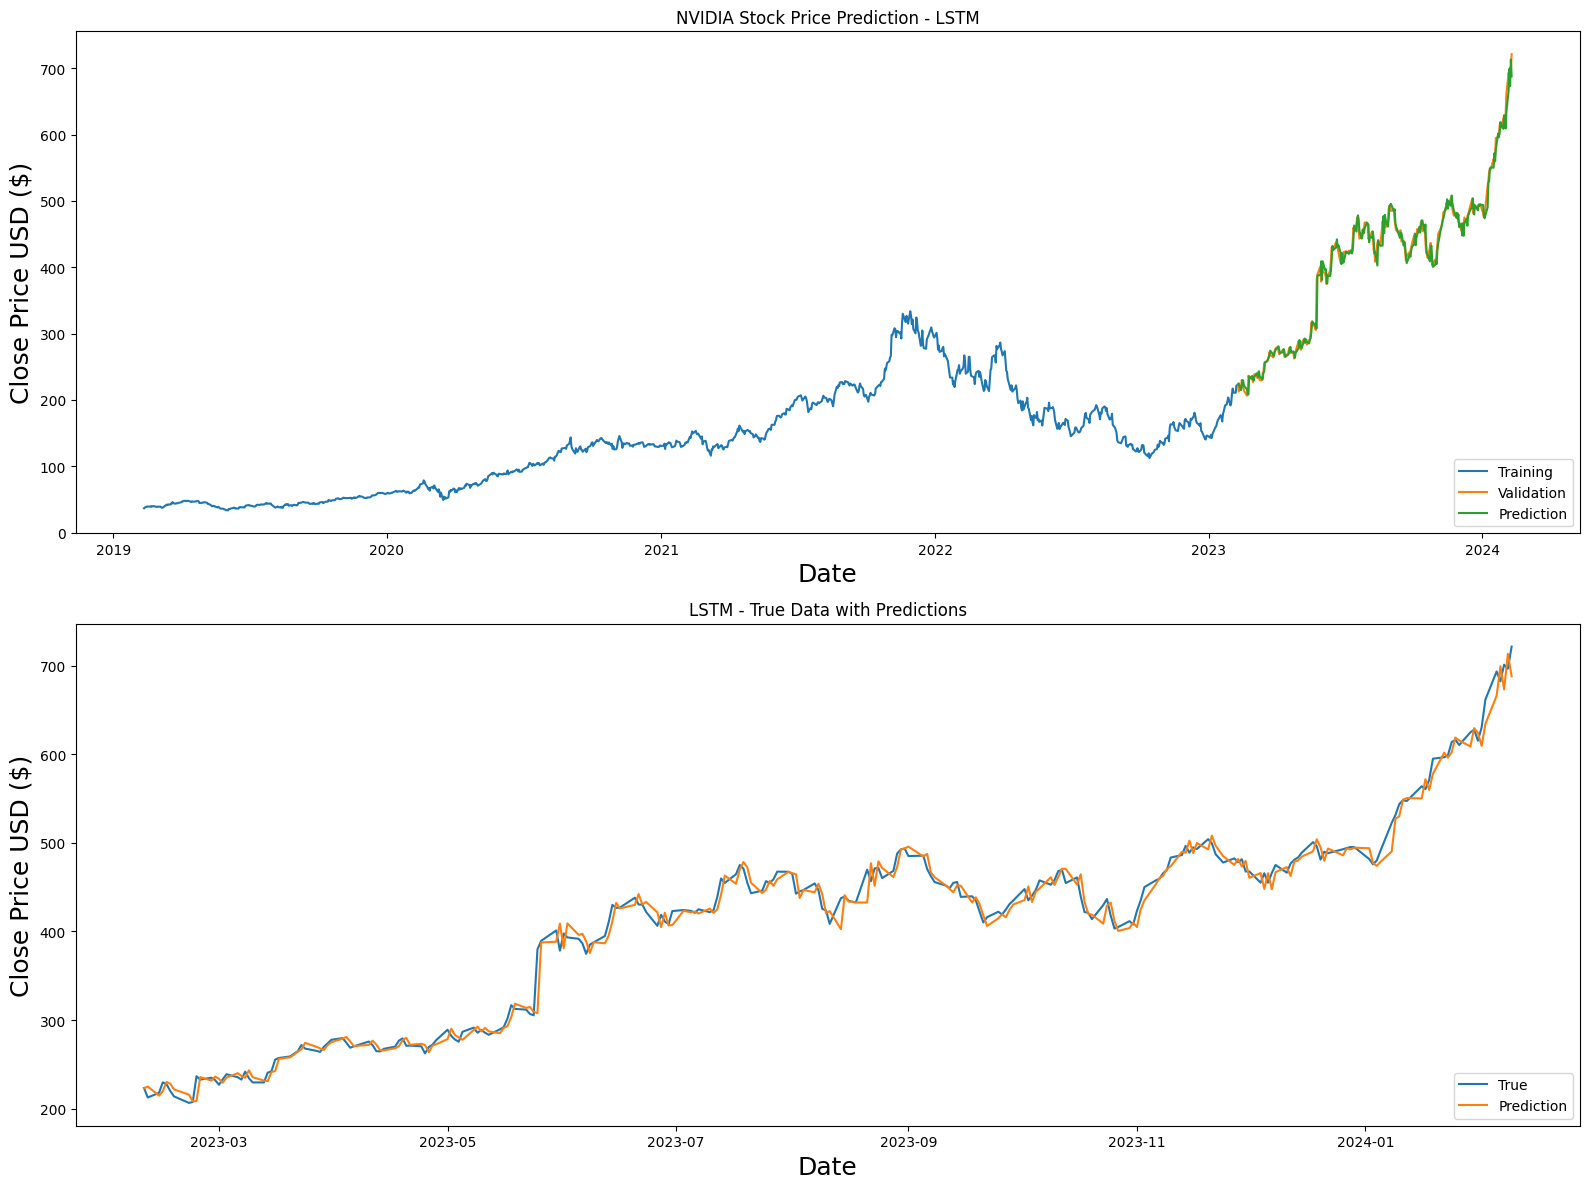

In [32]:
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions

fig, axs = plt.subplots(2, 1, figsize=(16, 12))

axs[0].plot(train['Close'], label='Train')
axs[0].plot(valid[['Close', 'Predictions']])
axs[0].set_title('NVIDIA Stock Price Prediction - LSTM')
axs[0].set_xlabel('Date', fontsize=18)
axs[0].set_ylabel('Close Price USD ($)', fontsize=18)
axs[0].legend(['Training', 'Validation', 'Prediction'], loc='lower right')

axs[1].plot(valid['Close'], label='True Data')
axs[1].plot(valid['Predictions'])
axs[1].set_title('LSTM - True Data with Predictions')
axs[1].set_xlabel('Date', fontsize=18)
axs[1].set_ylabel('Close Price USD ($)', fontsize=18)
axs[1].legend(['True', 'Prediction'], loc='lower right')

plt.tight_layout()
plt.show()
